# User-level analysis of political subreddits

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import *
from backbone import disparity_filter

## load data

In [2]:
year = 2012
df = build_df_year(year, with_text=True, with_time=False, filter_null=True) # start with yearly analysis
generate_index()

from utils import USERS, SUBREDDITS, user2index, index2user, subr2index, index2subr

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012
- number of entries: 5994991


In [4]:
# subsetting
active_user_ls = pd.read_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS5_100.csv").author.tolist()  # smaller one
# active_user_ls = pd.read_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS_2_2_50.csv").author.tolist()
df = df[df["author"].isin(active_user_ls)]

## build network

In [5]:
def build_user_graph(df):
    subm_aggr = df.groupby("submission_id").agg({"author": lambda x: set(list(x))}).reset_index()
    subm_aggr["n_user"] = subm_aggr["author"].map(lambda x: len(x))
    subm_aggr = subm_aggr[subm_aggr["n_user"]>1].reset_index().drop(columns=["index"])  
    
    user_edges = {}
    print("recording edges...")
    # directly writing to nx.Graph() kills the kernel, ugh
    for i,row in subm_aggr.iterrows():
        users = list(row["author"])
        if i%10000==0: print(" - progress:", i/len(subm_aggr))
        userpairs = [*combinations(users,2)]
        for i,up in enumerate(userpairs):
            u1 = min(user2index[up[0]],user2index[up[1]])
            u2 = max(user2index[up[0]],user2index[up[1]])
            try:
                user_edges[(u1, u2)] += 1
            except:
                user_edges[(u1, u2)] = 1
                
    print("building graph...")       
    userg = nx.Graph()
    for p,w in user_edges.items():
        userg.add_edge(p[0], p[1], weight=w)
    
    print("graph descriptives:")
    print(" - # of nodes:", len(userg.nodes()))
    print(" - # of edges:", len(userg.edges()))
    return user_edges, userg

In [6]:
user_edges, userg = build_user_graph(df)  # should take a while

recording edges...
 - progress: 0.0
 - progress: 0.05656172581137796
 - progress: 0.11312345162275592
 - progress: 0.16968517743413386
 - progress: 0.22624690324551183
 - progress: 0.2828086290568898
 - progress: 0.3393703548682677
 - progress: 0.3959320806796457
 - progress: 0.45249380649102366
 - progress: 0.5090555323024016
 - progress: 0.5656172581137796
 - progress: 0.6221789839251575
 - progress: 0.6787407097365354
 - progress: 0.7353024355479134
 - progress: 0.7918641613592914
 - progress: 0.8484258871706694
 - progress: 0.9049876129820473
 - progress: 0.9615493387934253
building graph...
graph descriptives:
 - # of nodes: 21415
 - # of edges: 52689273


In [7]:
# nx.write_gpickle(userg, ROOTPATH + f"output/user_graph_{year}.gpickle")

## degree and strength distribution

In [16]:
degs = list(dict(userg.degree()).values())
strs = list(dict(userg.degree(weight="weight")).values())

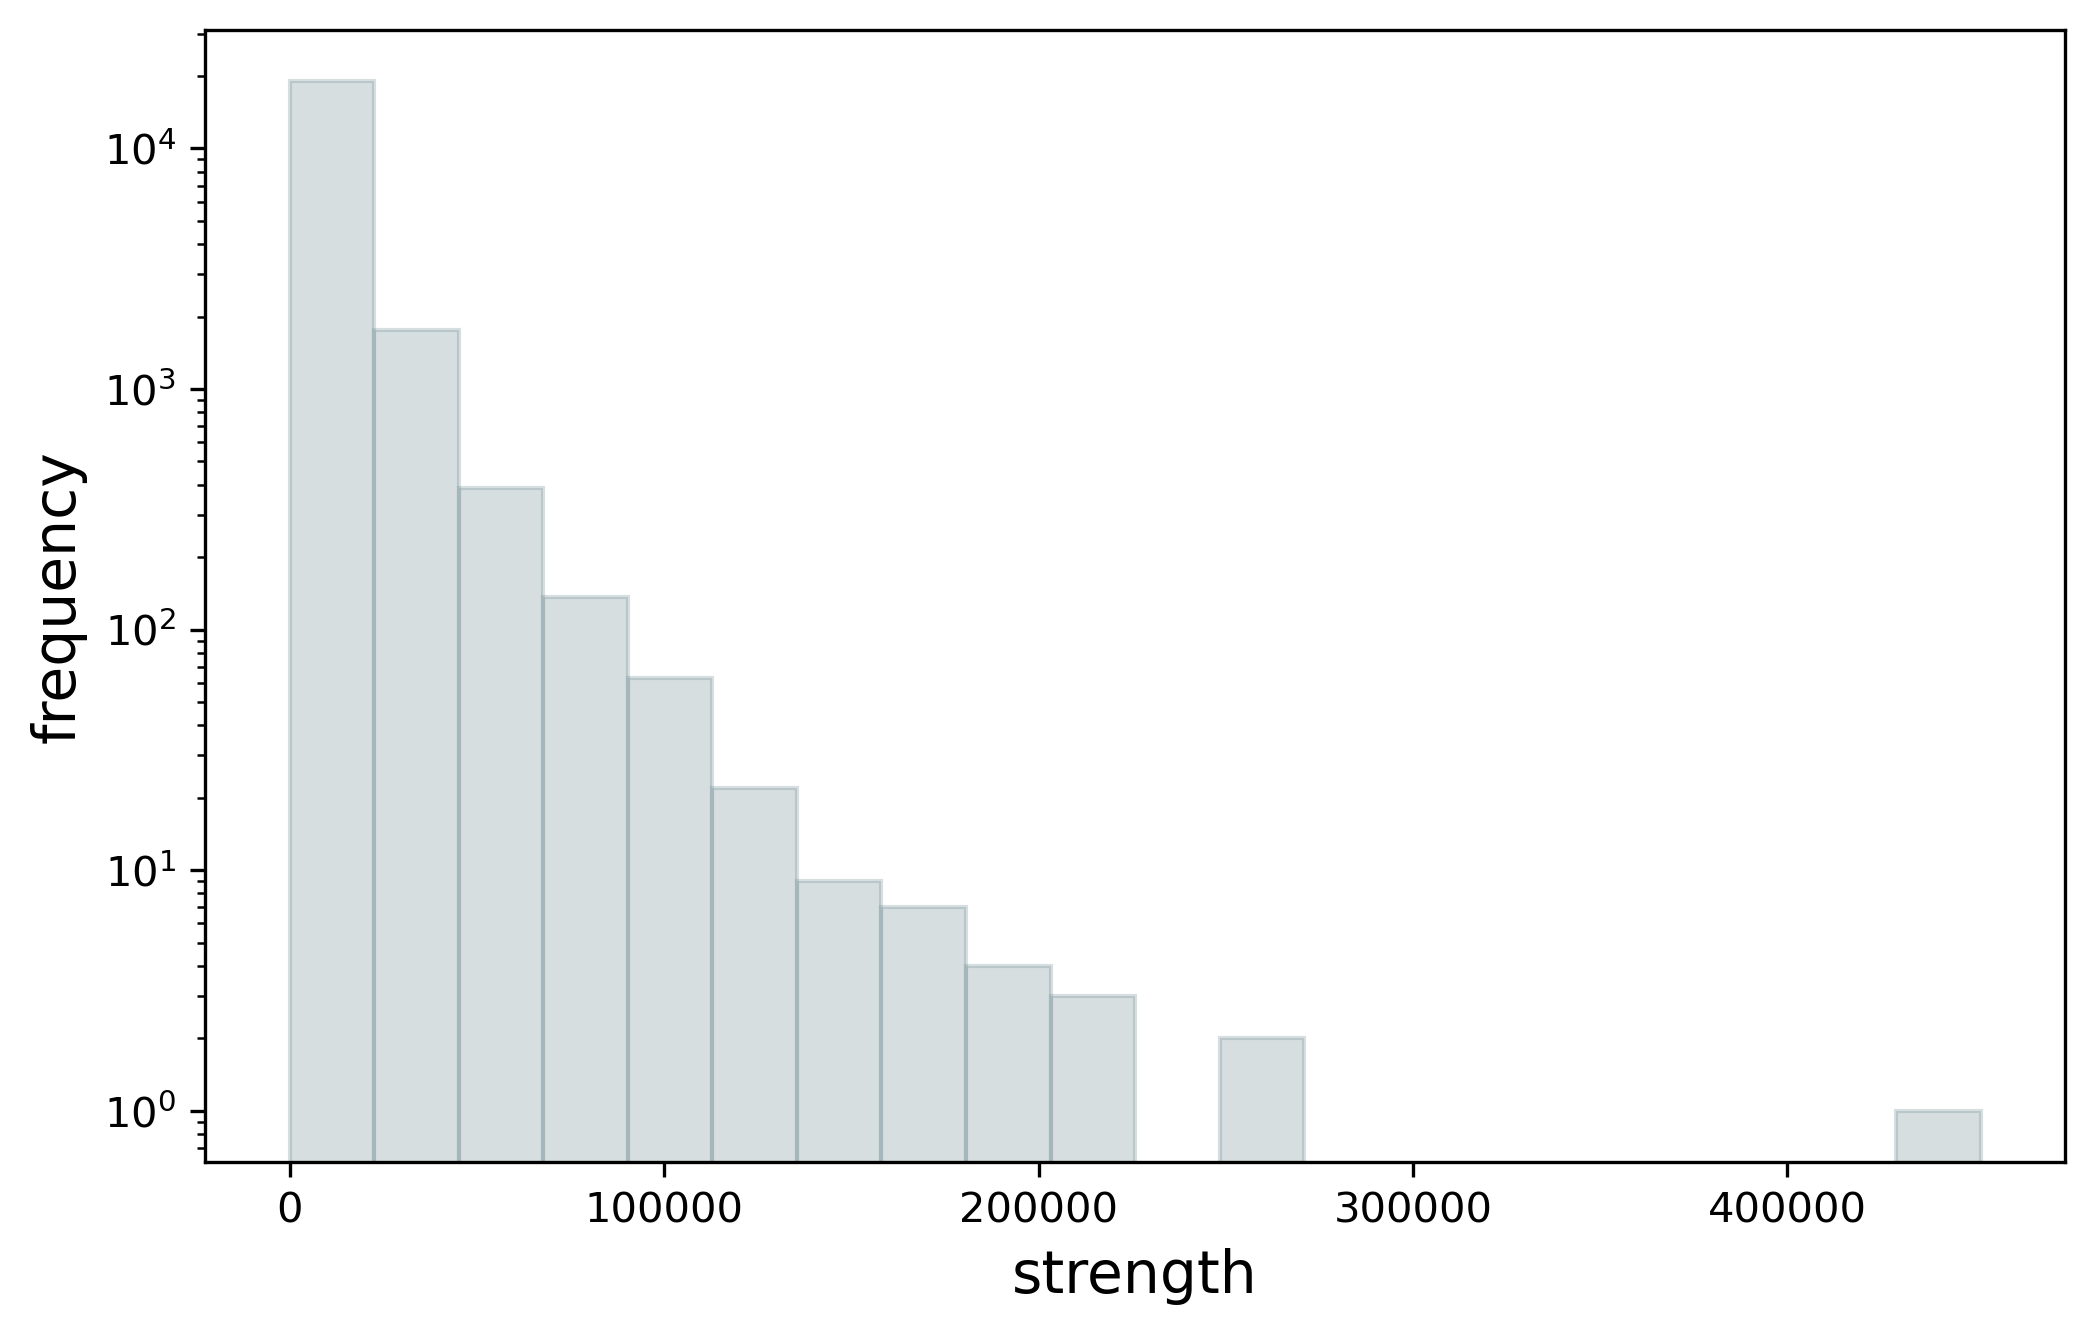

In [37]:
fig,ax = plt.subplots(figsize=(8,5), dpi=300)
plt.hist(strs, bins=20, edgecolor="#7A9299", color="#7A9299", alpha=0.3)
plt.yscale("log")
plt.xlabel("strength", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.savefig(ROOTPATH + f"output/fig/user_strength_{year}.png", dpi=300)

## toxicity level and strength

In [38]:
nodedf = pd.DataFrame()
nodedf["Id"] = [*userg.nodes()]
nodedf["author"] = nodedf["Id"].map(lambda x: index2user[x])
nodedf["degree"] = degs
nodedf["strength"] = strs
nodedf["strength_logged"] = nodedf["strength"].map(lambda x: np.log(x))
nodedf["degree_logged"] = nodedf["strength"].map(lambda x: np.log(x))

In [40]:
# get toxicity score for individual users
aggr_func = {"toxicity": lambda x: list(x)}
user_toxicity = df[["author","toxicity"]][df["toxicity"].notna()].groupby("author").agg(aggr_func).reset_index()
nodedf = nodedf.merge(user_toxicity, on="author", how="left")

nodedf["mean_tox"] = nodedf["toxicity"].map(lambda x: np.mean(x))
nodedf["max_tox"] = nodedf["toxicity"].map(lambda x: max(x) if str(x)!="nan" else np.NaN)
nodedf["min_tox"] = nodedf["toxicity"].map(lambda x: min(x) if str(x)!="nan" else np.NaN)
nodedf["range_tox"] = nodedf["toxicity"].map(lambda x: max(x)-min(x) if str(x)!="nan" else np.NaN)
nodedf["var_tox"] = nodedf["toxicity"].map(lambda x: np.var(x) if str(x)!="nan" else np.NaN)

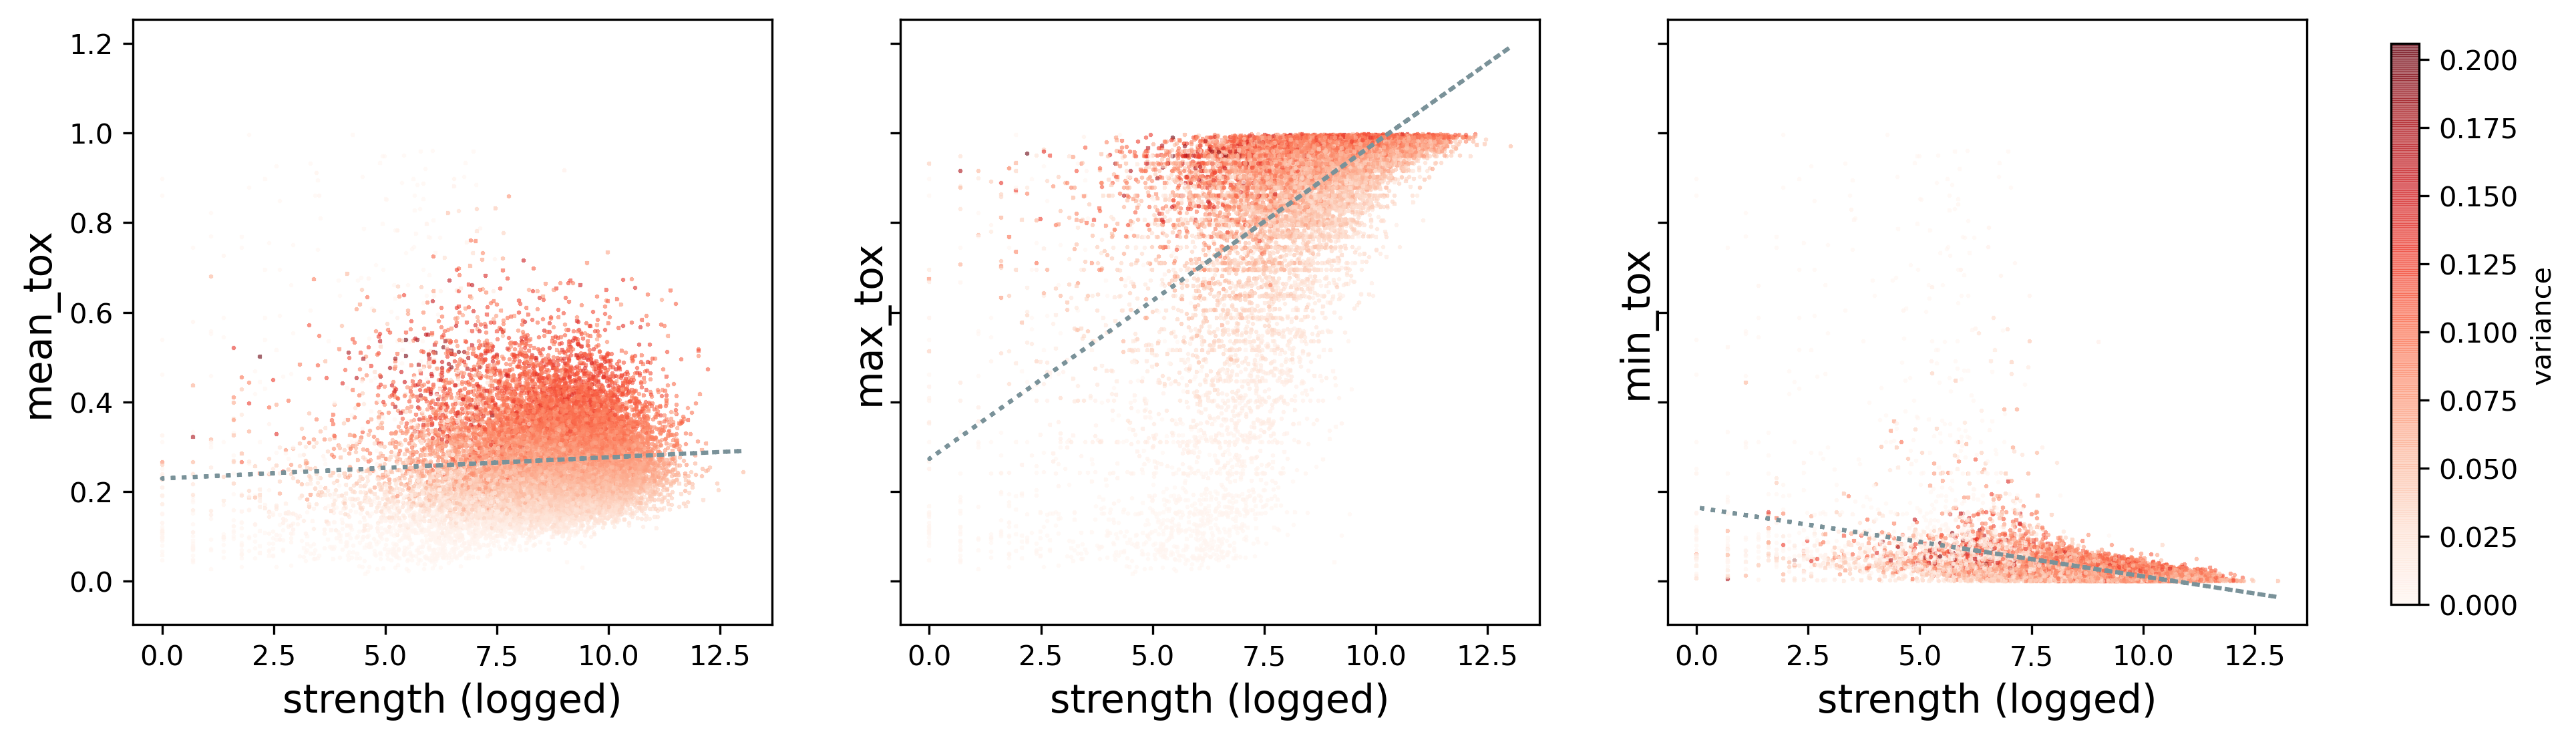

In [49]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4), sharex=True, sharey=True, dpi=300)
for i,col in enumerate(["mean_tox", "max_tox", "min_tox"]):
    filtered_df = nodedf.dropna(subset=["strength_logged", col])
    x = filtered_df["strength_logged"]
    y = filtered_df[col]

    # scatterplot
    _ = ax[i].scatter(x, y, cmap="Reds", c=filtered_df["var_tox"], alpha=0.6, s=1, marker="+")
    
    # OLS
    m,b = np.polyfit(x, y, 1)
    ax[i].plot(x, m*x+b, ":", color="#7A9299")
    ax[i].set_xlabel("strength (logged)", fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
fig.colorbar(_, cax=fig.add_axes([0.93, 0.15, 0.01, 0.7]), label="variance")
plt.savefig(ROOTPATH + f"output/fig/user_strength_tox_{year}.png", dpi=300)

### OLS fitness?

In [50]:
def OLS_fit(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print(results.params)
    print(print(results.summary()))

In [52]:
for col in ["mean_tox", "max_tox", "min_tox"]:
    print("\n\n********* OLS *********")
    print("x = strength")
    print("y =", col, "\n")
    OLS_fit(nodedf.dropna()["strength_logged"], nodedf.dropna()[col])



********* OLS *********
x = strength
y = mean_tox 

const              0.229439
strength_logged    0.004723
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               mean_tox   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.96e-29
Time:                        19:47:57   Log-Likelihood:                 18749.
No. Observations:               21406   AIC:                        -3.749e+04
Df Residuals:                   21404   BIC:                        -3.748e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-

## static TFP

Are my neighbors are on average more toxic than me?

In [53]:
TOXICITY_DICT = nodedf[["Id","mean_tox"]].set_index("Id").to_dict()["mean_tox"]

In [54]:
def examine_gfps(g):
    gfps = []
    for i,(n,v) in enumerate(TOXICITY_DICT.items()):
        if i%1000==0: print("progress:", i/len(TOXICITY_DICT))
        neighbors = g[n]
        my_tox = v
        env_tox = np.mean([TOXICITY_DICT[x] for x in neighbors])
        if my_tox > env_tox:  # I'm more toxic than my neighbors
            gfps.append(0)
        else:  # my neighbors are more toxic than me
            gfps.append(1)
    nodedf["gfp"] = gfps

In [62]:
examine_gfps(userg)

progress: 0.0
progress: 0.046696240952603316
progress: 0.09339248190520663
progress: 0.14008872285780993
progress: 0.18678496381041326
progress: 0.23348120476301656
progress: 0.28017744571561987
progress: 0.3268736866682232
progress: 0.3735699276208265
progress: 0.42026616857342985
progress: 0.46696240952603313
progress: 0.5136586504786365
progress: 0.5603548914312397
progress: 0.6070511323838431
progress: 0.6537473733364464
progress: 0.7004436142890498
progress: 0.747139855241653
progress: 0.7938360961942563
progress: 0.8405323371468597
progress: 0.887228578099463
progress: 0.9339248190520663
progress: 0.9806210600046696


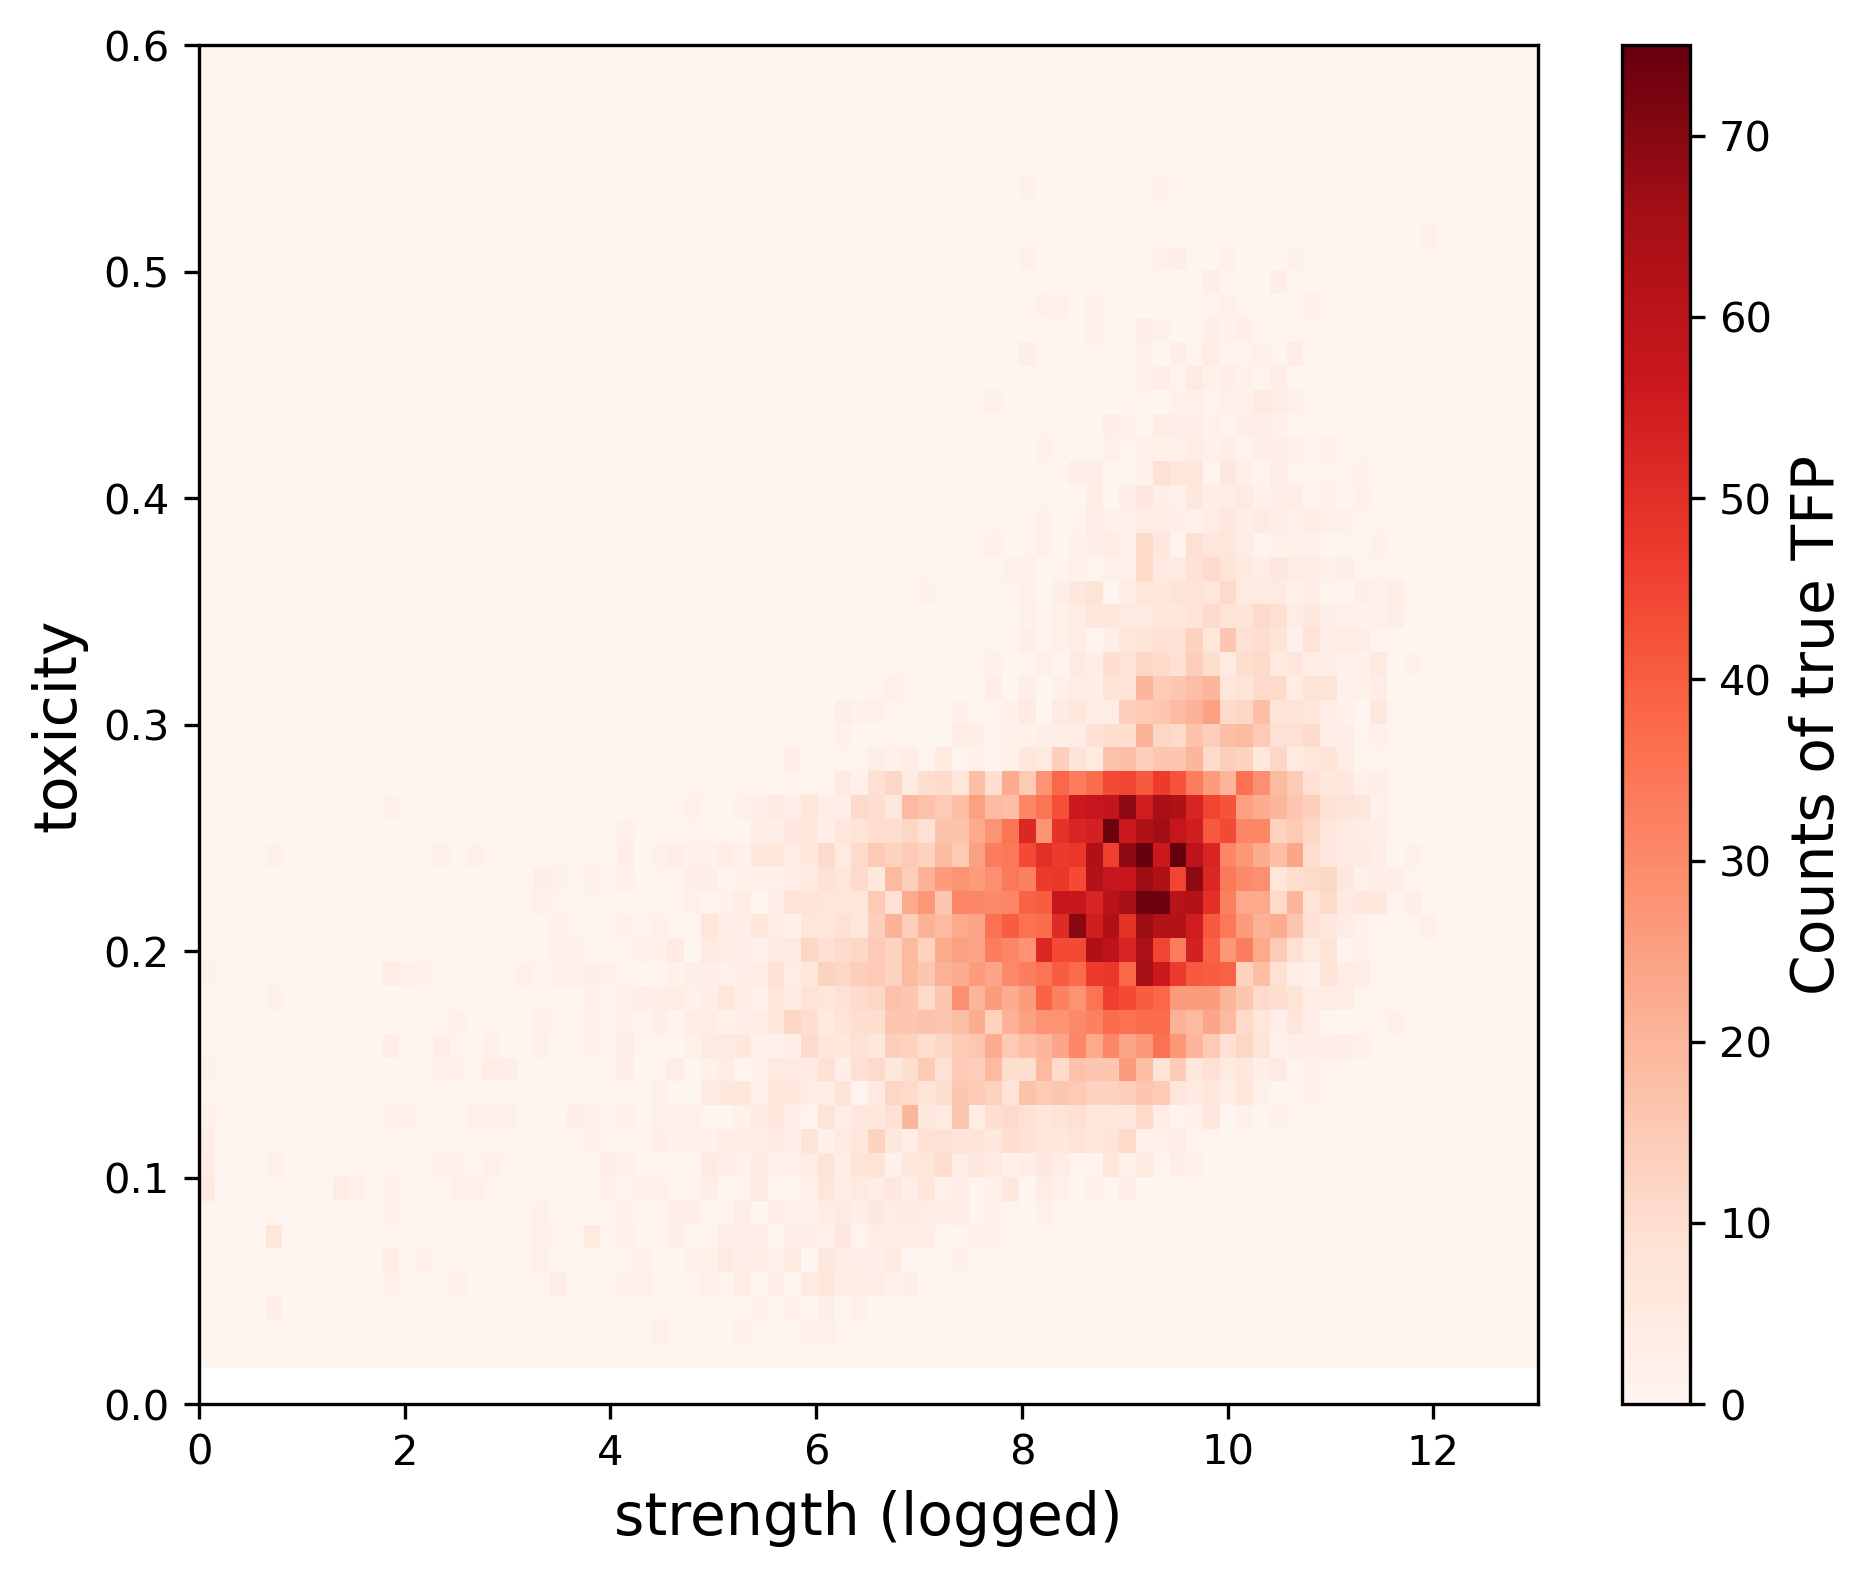

In [81]:
fig, ax = plt.subplots(figsize=(7.2,6), dpi=300)
x = nodedf[nodedf["gfp"]==1].dropna()["degree_logged"]
y = nodedf[nodedf["gfp"]==1].dropna()["mean_tox"]
plt.hist2d(x, y, (80,80), cmap="Reds")
plt.xlabel("strength (logged)", fontsize=14)
plt.ylabel("toxicity", fontsize=14)
ax.set_ylim(0,0.6)
plt.colorbar().set_label(label="Counts of true TFP",size=14)
plt.savefig(ROOTPATH + f"output/fig/fpg{year}.png", dpi=300)